In [1]:
# Please install openpyxl and odfpy from pip or anaconda in order to import the inout data files
import sys
# !{sys.executable} -m pip install openpyxl
# !{sys.executable} -m pip install odfpy

# Import libraries and set plot styles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warning for chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

# Show plots inline
%matplotlib inline

# Set plot style
# plot.style.available
plt.style.use('fivethirtyeight')

In [4]:
# Read in and preview data
df = pd.read_csv('data/agg_data_inner_11_cis_mar22.csv',
                 parse_dates=['date'],
                 dayfirst=True)
df1 = pd.read_excel('data/Region Mapping.xlsx')
df2 = pd.read_excel('data/R_and_growth_rate_time_series_for_publication_v1.0.ods',
                    sheet_name=2,
                    engine='odf',
                    header=[7,8], #Two rows of header
                    na_values='.'
                    )
real_cases = pd.read_csv("data/region_2022-07-01.csv")
region_weights = pd.read_excel("data/Region Intersection.xlsx",
                                sheet_name=0)
region_weights = region_weights.iloc[:, [3,12,19]] # select region names (administrative and NHS) and arae

# Check for missing values
# df.isnull().sum()

In [5]:
# Select header titles and data range
df1.columns = df1.iloc[2]
region_map = df1.iloc[3:, :]
r_val = df2.iloc[:, 1:]

# Merge 2 header rows
r_val.columns = ['_'.join(header).upper() for header in r_val.columns]
r_val.drop(['UK_UPPER BOUND', 'UK_LOWER BOUND'], axis=1)

# Remove missing values
region_map.dropna()
r_val = r_val.dropna()

# Rename specific columns for joining
df.rename(columns={'cis20cd': 'CIS20CD'}, inplace=True)
df.rename(columns={'grab_compo_boo': 'compo_frac'}, inplace=True)
region_map.rename(columns={'Geography Code': 'CIS20CD', 'Region': 'region'}, inplace=True)
r_val.rename(columns={'DATE_UNNAMED: 1_LEVEL_1': 'date'}, inplace=True)
region_weights.rename(columns={'nhser20nm': 'nhs_region', 'rgn17nm': 'region'}, inplace=True)

# Lower case all strings for easy joining
region_map['region'] = region_map['region'].str.lower()
real_cases['areaName'] = real_cases['areaName'].str.lower()
region_weights = region_weights.applymap(lambda s: s.lower() if type(s) == str else s)

### Copied from UKHSA code ###
# Variable labels that are not changed
variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    #'control_gc_l_mean':'control volume',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'compo_frac':'composites fraction',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

In [6]:
df['date'] = pd.to_datetime(df['date'])
# tmp = pd.to_datetime(r_val['date'],
#                      format = '%Y-%m-%d %H:%M:%S',
#                      errors='coerce')
# r_val.date = r_val.date.where(tmp.isna(), tmp.dt.date)
r_val['date'] = pd.to_datetime(r_val['date'])
real_cases['date'] = pd.to_datetime(real_cases['date'])
real_cases = real_cases[real_cases['date'].between('2020-07-01', '2021-02-28')]

# df.head()
# region_map.head()
# r_val.head()
# region_weights

# Check R values shortly before study period (for out-of-range interpolation)
# r_val[r_val['date'].between('2020-08-20','2020-09-07')]

### Generate average r values for each region

In [8]:
# r_val['UK_AVERAGE'] = r_val[['UK_LOWER BOUND', 'UK_UPPER BOUND']].mean(axis=1)
r_val['ENGLAND_AVERAGE'] = r_val[['ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['EAST OF ENGLAND_AVERAGE'] = r_val[['EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND']].mean(axis=1)
r_val['LONDON_AVERAGE'] = r_val[['LONDON_LOWER BOUND', 'LONDON_UPPER BOUND']].mean(axis=1)
r_val['MIDLANDS_AVERAGE'] = r_val[['MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND']].mean(axis=1)
r_val['NORTH EAST AND YORKSHIRE_AVERAGE'] = r_val[['NORTH EAST AND YORKSHIRE_LOWER BOUND', 'NORTH EAST AND YORKSHIRE_UPPER BOUND']].mean(axis=1)
r_val['NORTH WEST_AVERAGE'] = r_val[['NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH EAST_AVERAGE'] = r_val[['SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND']].mean(axis=1)
r_val['SOUTH WEST_AVERAGE'] = r_val[['SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND']].mean(axis=1)

# Export averages of R
melt_r_a = pd.melt(r_val[['date', 'ENGLAND_AVERAGE', #'ENGLAND_LOWER BOUND', 'ENGLAND_UPPER BOUND',
                        'EAST OF ENGLAND_AVERAGE', #'EAST OF ENGLAND_LOWER BOUND', 'EAST OF ENGLAND_UPPER BOUND',
                        'LONDON_AVERAGE', #'LONDON_LOWER BOUND', 'LONDON_UPPER BOUND',
                        'MIDLANDS_AVERAGE', #'MIDLANDS_LOWER BOUND', 'MIDLANDS_UPPER BOUND',
                        'NORTH EAST AND YORKSHIRE_AVERAGE', #'NORTH EAST AND YORKSHIRE_LOWER BOUND',
                        #'NORTH EAST AND YORKSHIRE_UPPER BOUND',
                        'NORTH WEST_AVERAGE', #'NORTH WEST_LOWER BOUND', 'NORTH WEST_UPPER BOUND',
                        'SOUTH EAST_AVERAGE', #'SOUTH EAST_LOWER BOUND', 'SOUTH EAST_UPPER BOUND',
                        'SOUTH WEST_AVERAGE', #'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_UPPER BOUND'
                        ]],
                 id_vars=['date'])

melt_r_u = pd.melt(r_val[['date', 'ENGLAND_UPPER BOUND',
                          'EAST OF ENGLAND_UPPER BOUND',
                          'LONDON_UPPER BOUND',
                          'MIDLANDS_UPPER BOUND',
                          'NORTH EAST AND YORKSHIRE_UPPER BOUND',
                          'NORTH WEST_UPPER BOUND',
                          'SOUTH EAST_UPPER BOUND',
                          'SOUTH WEST_UPPER BOUND'
                          ]],
                   id_vars=['date'])

melt_r_l = pd.melt(r_val[['date', 'ENGLAND_LOWER BOUND',
                          'EAST OF ENGLAND_LOWER BOUND',
                          'LONDON_LOWER BOUND',
                          'MIDLANDS_LOWER BOUND',
                          'NORTH EAST AND YORKSHIRE_LOWER BOUND',
                          'NORTH WEST_LOWER BOUND',
                          'SOUTH EAST_LOWER BOUND',
                          'SOUTH WEST_LOWER BOUND'
                          ]],
                   id_vars=['date'])

# Create column for join
melt_r_a['nhs_region'] = melt_r_a['variable'].map(lambda x: str(x)[:-8].lower())
melt_r_u['nhs_region'] = melt_r_u['variable'].map(lambda x: str(x)[:-12].lower())
melt_r_l['nhs_region'] = melt_r_l['variable'].map(lambda x: str(x)[:-12].lower())

r_cleaned = pd.merge(pd.merge(melt_r_a, melt_r_l, on=['date', 'nhs_region'], how='left'),
                     melt_r_u, on=['date', 'nhs_region'], how='outer')

# Rename and drop columns
r_cleaned.rename(columns={'value_x': 'r_avg', 'value_y': 'r_lower', 'value':'r_upper'}, inplace=True)
r_cleaned = r_cleaned[['date', 'nhs_region', 'r_lower', 'r_avg', 'r_upper']]

### Linkage

In [9]:
# Match region to codes in wastewater data
df3 = pd.merge(df, region_map[['CIS20CD', 'Country', 'region']], on='CIS20CD', how='left')

# Weighted average
grouped = df3.groupby(['region', 'date'])

def wavg(group):
    d = group['sars_cov2_gc_l_mean']
    w = group['catchment_population_ons_mid_2019']
    return ((d * w).sum() / w.sum()), ((d * w).sum()*400), w.sum()
    # return 1) weighted average of RNA level, 2) gene copies per day assuming 400L/person/d and 3) regional population

df4= grouped.apply(wavg)
df4 = df4.reset_index()
df4.rename(columns={0: 'temp'}, inplace=True) # rename weighted average column
df4['weighted_avg_sars_cov2'], df4['gene_copies_per_day'], df4['regional_pop'] = zip(*df4.temp)
# assign function output into separate columns
df4 = df4.drop(columns='temp')

In [10]:
# Join average R estimates (7 NHS regions) and weights of 9 administrative regions
df5 = pd.merge(region_weights, r_cleaned, on='nhs_region', how='left')

In [11]:
# Weighted average of R values
grouped2 = df5.dropna().groupby(['region', 'date'])

def wavg2(group):
    rl = group['r_lower']
    ra = group['r_avg']
    ru = group['r_upper']
    w = group['area']
    return (rl * w).sum() / w.sum(), (ra * w).sum() / w.sum(), (ru* w).sum() / w.sum()

weighted_r = grouped2.apply(wavg2)
weighted_r = weighted_r.reset_index()
weighted_r.rename(columns={0: 'temp'}, inplace=True) # rename weighted average column
weighted_r['avg_r_lower'], weighted_r['avg_r_avg'], weighted_r['avg_r_upper'] = zip(*weighted_r.temp)
weighted_r = weighted_r.drop(columns='temp')

# Check number of regions
weighted_r.region.nunique()

In [12]:
# Weighted average of other chemical measures in wastewater

def wavg3(group):
    ss = group['suspended_solids_mg_l']
    a = group['ammonia_mg_l']
    o = group['ophosph_mg_l']
    ph = group['sample_ph_pre_ansis']
    ctrl = group['control_gc_l_mean']
    rvc = group['reac_vol_control']
    ra = group['raw_ansis_sars_repc_std']
    cf = group['compo_frac']
    sblod = group['sars_below_lod']
    sbloq = group['sars_below_loq']
    rd = group['reception_delay']
    w = group['catchment_population_ons_mid_2019']
    return (ss * w).sum() / w.sum(), (a * w).sum() / w.sum(), (o * w).sum() / w.sum(), (ph * w).sum() / w.sum(), (ctrl * w).sum() / w.sum(), (rvc * w).sum() / w.sum(), (ra * w).sum() / w.sum(), (cf * w).sum() / w.sum(), (sblod* w).sum() / w.sum(), (sbloq * w).sum() / w.sum(), (rd * w).sum() / w.sum()

chem = grouped.apply(wavg3)
chem = chem.reset_index()
chem.rename(columns={0: 'temp'}, inplace=True) # rename weighted average column
chem['suspended_solids_mg_l'], chem['ammonia_mg_l'], chem['ophosph_mg_l'], chem['sample_ph_pre_ansis'], chem['control_gc_l_mean'], chem['reac_vol_control'], chem['raw_ansis_sars_repc_std'], chem['compo_frac'], chem['sars_below_lod'], chem['sars_below_loq'], chem['reception_delay'] = zip(*chem.temp)

In [13]:
# Match with R values
model_dataset = pd.merge(df4, weighted_r, on=['date', 'region'], how='left')

# Merge with all variables
all_var_dataset = pd.merge(model_dataset, chem, on=['date', 'region'], how='left').dropna()

model_dataset = all_var_dataset

In [14]:
# # Dimension of dataframe
# model_dataset.shape
#
# # Number of unique sites
# model_dataset.region.nunique()
#
# # Date range
# print('Study period from', model_dataset.date.min(), 'to', model_dataset.date.max())

# Get total population of each region for each unique date
population_sum = grouped['catchment_population_ons_mid_2019'].sum()

#### Subsets

In [15]:
# # Create a class object holding all subsets (not sure how to perform interpolation over it, tbc)
# class model_dataset_names:
#     pass
#
# subset_model_dataset = model_dataset_names()
#
# subsets = model_dataset['region'].unique()
#
# for subset in subsets:
#     setattr(subset_model_dataset, f"{subset}", model_dataset[model_dataset['region']==subset].reset_index(drop=True))
#
# for subset in subsets:
#     print(getattr(subset_model_dataset, f"{subset}"))

In [16]:
subset_sw = model_dataset.loc[(model_dataset['region'] == 'south west'),:]
subset_se = model_dataset.loc[(model_dataset['region'] == 'south east'),:]
subset_ldn = model_dataset.loc[(model_dataset['region'] == 'london'),:]
subset_ee = model_dataset.loc[(model_dataset['region'] == 'east of england'),:]
subset_em = model_dataset.loc[(model_dataset['region'] == 'east midlands'),:]
subset_wm = model_dataset.loc[(model_dataset['region'] == 'west midlands'),:]
subset_nw = model_dataset.loc[(model_dataset['region'] == 'north west'),:]
subset_ne = model_dataset.loc[(model_dataset['region'] == 'north east'),:]
subset_yh = model_dataset.loc[(model_dataset['region'] == 'yorkshire and the humber'),:]

In [17]:
subsets = [subset_sw, subset_se, subset_ldn, subset_ee, subset_em, subset_wm, subset_nw, subset_ne, subset_yh]

#### Perform interpolation into daily data

In [18]:
def interpolation(subset):
    # Set index as date to perform interpolation
    subset.index = subset['date']
    # del subset['date']

    # Linear interpolation
    daily_interpol = subset.resample('D').mean().interpolate('linear')
    # daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()

    # This would remove the first rows without interpolated r values -> to be fixed
    daily_interpol = daily_interpol.dropna().reset_index()

    # log-transformation
    daily_interpol['log_weighted_avg'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])
    daily_interpol['log_gc_per_day'] = np.log10(daily_interpol['gene_copies_per_day'])
    return daily_interpol

In [19]:
# Interpolate over all subsets
# Create an empty list of dataframes first
interpolated_subset = [pd.DataFrame() for x in range(9)]

for i in range(0,len(subsets)):
    interpolated_subset[i] = interpolation(subsets[i])

In [20]:
# Add regions name
for i in range(0,len(interpolated_subset)):
    interpolated_subset[i]['region'] = subsets[i]['region'][1]

In [21]:
combined_dataset = pd.concat(interpolated_subset)

In [22]:
# # Simplified version for all regions using dictionary (does not work)
# d = dict(tuple(model_dataset.groupby('region')))
# d.values()
#
# for key in d:
#     interpol = d.resample('D').mean().interpolate('linear')
#
# # Set index as date to perform interpolation
#
# model_dataset = model_dataset.set_index(['region', 'date'], inplace=True)
#
# # Linear interpolation
# daily_interpol_all = model_dataset.resample('D').mean().interpolate('linear')
# # daily_interpol['sars_cov2_gc_l_mean']=daily_interpol['sars_cov2_gc_l_mean'].interpolate()
#
# # Rolling average in a new column called mean_gene??
# # subset2 = daily_interpol.assign(mean_gene = daily_interpol['sars_cov2_gc_l_mean'].rolling(window=7).mean())
#
# # This would remove the first rows without interpolated r values -> to be fixed
# daily_interpol_all = daily_interpol_all.dropna().reset_index()
#
# # log-transformation
# daily_interpol_all['log_gene'] = np.log10(daily_interpol['weighted_avg_sars_cov2'])

### Data over time

In [26]:
# check if dataframe is indexed (should be False)
# pd.Index(np.arange(0, len(combined_dataset))).equals(combined_dataset.index)

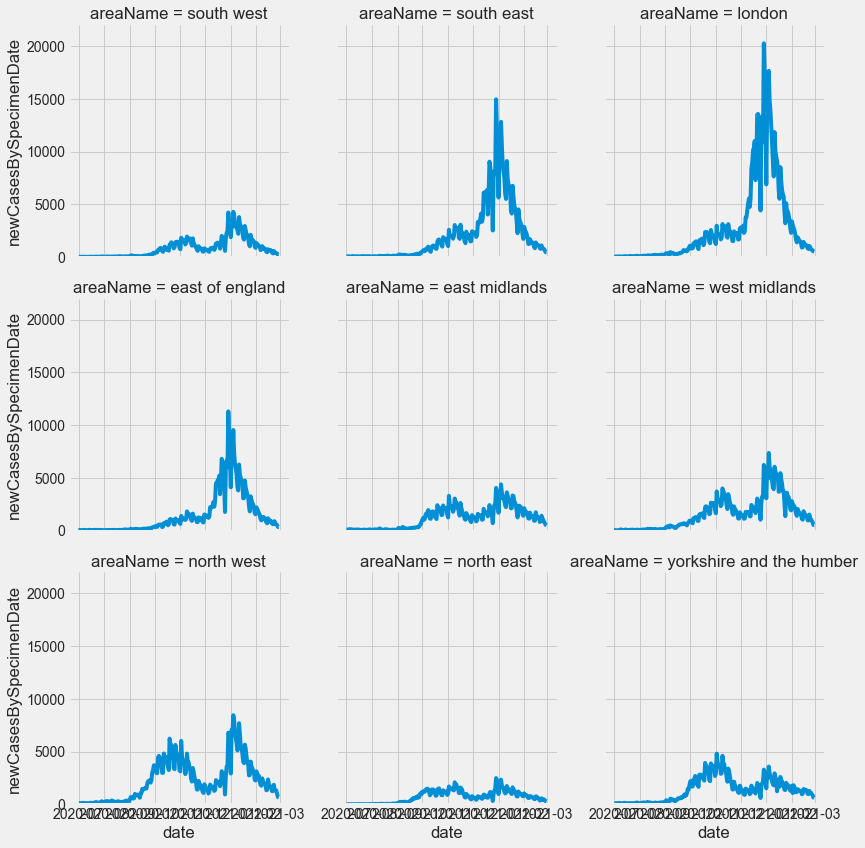

In [27]:
# EDA plots to compare before and after interpolation
# Red = after interpolation

# Raw RNA level over time
# plt.figure()
# sns.lineplot(data=combined_dataset, x="date", y="weighted_avg_sars_cov2", hue='region')
# plt.title('Raw RNA level Over Time')

# # Log RNA level over time
# plt.figure()
# sns.lineplot(data=combined_dataset, x="date", y="log_gene", hue='region')
# plt.title('Log RNA level Over Time')
#
# # Population of each region over time
# population_sum = population_sum.reset_index()
# plt.figure()
# ax = sns.lineplot(x='date', y='catchment_population_ons_mid_2019', hue='region', data=population_sum)
# ax.set_ylabel("Population")
# sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.2), ncol=3, title=None, frameon=False)
# plt.title('Population Over Time')
#
# # Real incidence of SW
# plt.figure()
# bx = sns.lineplot(data=real_cases, x="date", y='newCasesBySpecimenDate', hue='areaName')
# plt.title('New Cases by Specimen Date')
#

g = sns.FacetGrid(real_cases, col="areaName", col_wrap=3, height=4, ylim=(0, 22000),
                  col_order=['south west', 'south east', 'london',
                             'east of england', 'east midlands', 'west midlands',
                             'north west', 'north east', 'yorkshire and the humber'])
g.map(sns.lineplot, "date", "newCasesBySpecimenDate")

KeyError: "['weighted_average_r'] not in index"

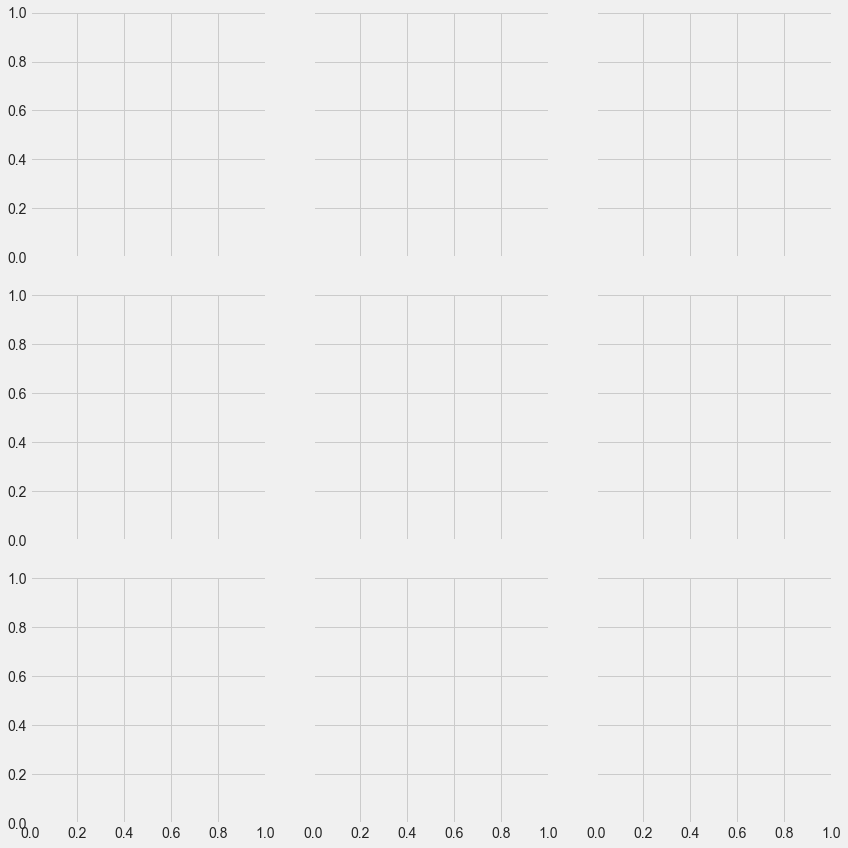

In [28]:
g = sns.FacetGrid(combined_dataset, col="region", col_wrap=3, height=4)
g.map(sns.lineplot, "date", "weighted_average_r")

In [ ]:
g = sns.FacetGrid(df3, col="region", col_wrap=3, height=4,
                  col_order=['south west', 'south east', 'london',
                             'east of england', 'east midlands', 'west midlands',
                             'north west', 'north east', 'yorkshire and the humber'])
g.map(sns.lineplot, "date", "sars_cov2_gc_l_mean")

In [ ]:
g = sns.FacetGrid(weighted_r, col="region", col_wrap=3, height=4,
                  col_order=['south west', 'south east', 'london',
                             'east of england', 'east midlands', 'west midlands',
                             'north west', 'north east', 'yorkshire and the humber'])
g.map(sns.lineplot, "date", "avg_r_avg")

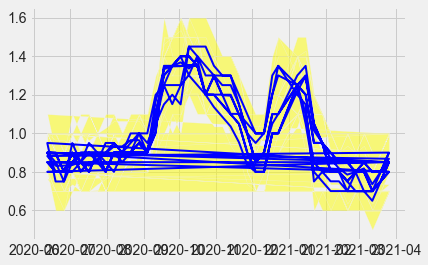

In [29]:
lower_bound = weighted_r['avg_r_lower']
upper_bound = weighted_r['avg_r_upper']

fig, ax = plt.subplots()
ax.plot(weighted_r['date'], weighted_r['avg_r_avg'], lw=2, color='blue')
ax.fill_between(weighted_r['date'], lower_bound, upper_bound, facecolor='yellow', alpha=0.5)

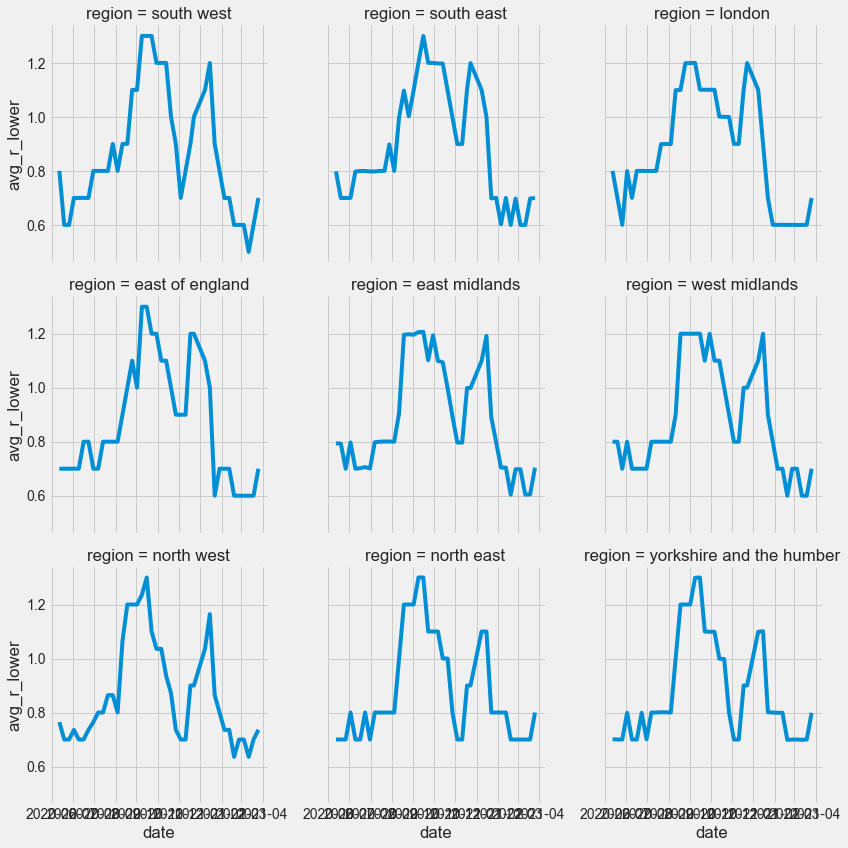

In [30]:
g = sns.FacetGrid(weighted_r, col="region", col_wrap=3, height=4,
                  col_order=['south west', 'south east', 'london',
                             'east of england', 'east midlands', 'west midlands',
                             'north west', 'north east', 'yorkshire and the humber'])
g.map(sns.lineplot, "date", "avg_r_lower")

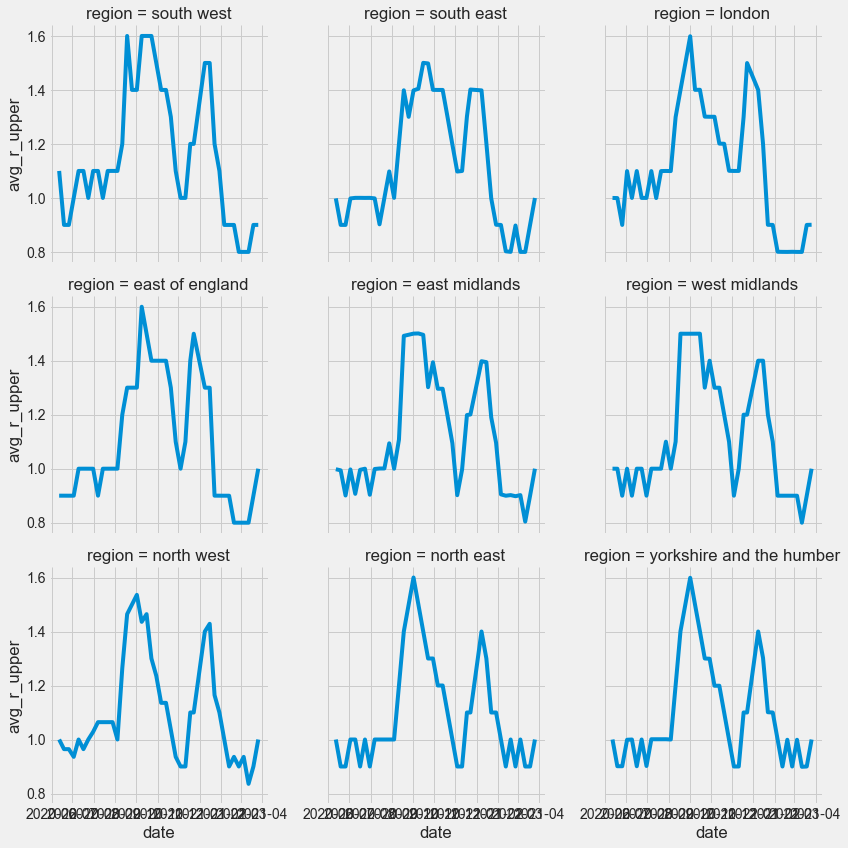

In [31]:
g = sns.FacetGrid(weighted_r, col="region", col_wrap=3, height=4,
                  col_order=['south west', 'south east', 'london',
                             'east of england', 'east midlands', 'west midlands',
                             'north west', 'north east', 'yorkshire and the humber'])
g.map(sns.lineplot, "date", "avg_r_upper")

In [33]:
# # Days that have lower population
# max(population_sum_sw['catchment_population_ons_mid_2019'])
# mask = population_sum_sw[population_sum_sw['catchment_population_ons_mid_2019']!=1711684.0]
# mask

### Relationship between RNA level and R value
For South West dataset only: to expand to all regions

In [37]:
melted_data = pd.melt(daily_interpol[['log_gene', 'SOUTH WEST_LOWER BOUND', 'SOUTH WEST_AVERAGE', 'SOUTH WEST_UPPER BOUND']], id_vars=['log_gene'])
melted_data2 = pd.merge(daily_interpol, real_case_sw, on='date', how='left')
melted_data2 = pd.melt(melted_data2[['log_gene', 'newCasesBySpecimenDate']], id_vars=['log_gene'])

NameError: name 'daily_interpol' is not defined

In [38]:
g = sns.scatterplot(data=melted_data, x='log_gene', y='value', hue='variable', marker='+')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('R estimates and log RNA level')

plt.figure()
h = sns.scatterplot(data=melted_data2, x='log_gene', y='value', hue='variable', marker='+', legend=False)
plt.title('Incidence and log RNA level')

NameError: name 'melted_data' is not defined

In [ ]:
# Check number of values under each site
# df3.CIS20CD.value_counts()

# Check number of zero values
# (df == 0).sum()

# Export Linked Datasets

In [36]:
# Write required datasets to csv file
combined_dataset.to_csv("data/linked_data.csv")
all_var_dataset.to_csv("data/all_var_dataset.csv")
r_cleaned.to_csv("data/r_val_cleaned.csv")
real_cases.to_csv("data/cleaned cases.csv")
weighted_r.to_csv("data/weighted_r.csv")
population_sum.to_csv('data/population_over_time.csv')

In [40]:
# Write each subset to a separate csv file
for i, outfile in zip(interpolated_subset, ["subsets/subset_sw.csv", "subsets/subset_se.csv",
                                            "subsets/subset_ldn.csv","subsets/subset_ee.csv",
                                            "subsets/subset_em.csv", "subsets/subset_wm.csv",
                                            "subsets/subset_nw.csv", "subsets/subset_ne.csv",
                                            "subsets/subset_yh.csv"]):
    i.to_csv(outfile)